In [1]:
# Use Resnet12: 25 epochs | "catsDogs_resnet_25.pth"
# Make density plots for setups 1 and 2 with NearOOD and FarOOD highlighted.

# Perhaps even:
# Use Resnet3: 150 epochs | "celebFaces_resnet150.pth"
# Make density plot for setup 3 with NearOOD and FarOOD highlighted.

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
cuda = torch.cuda.is_available()
cuda =False
device = 'cuda' if cuda else 'cpu'
%matplotlib inline

In [3]:
# Overview of ID class names and class identifiers
class_dict = {  "Abyssinian": 0,
                "american_bulldog": 1,
                "american_pit_bull_terrier": 2,
                "basset_hound": 3,
                "beagle": 4,
                "Bengal": 5,
                "Birman": 6,
                "Bombay": 7,
                "boxer": 8,
                "British_Shorthair": 9,
                "chihuahua": 10,
                "Egyptian_Mau": 11,
                "english_cocker_spaniel": 12,
                "english_setter": 13,
                "german_shorthaired": 14,
                "great_pyrenees": 15,
                "havanese": 16,
                "japanese_chin": 17,
                "keeshond": 18,
                "leonberger": 19,
                "Maine_Coon": 20,
                "miniature_pinscher": 21,
                "newfoundland": 22,
                "Persian": 23,
                "pomeranian": 24,
                "pug": 25,
                "Ragdoll": 26,
                "Russian_Blue": 27,
                "saint_bernard": 28,
                "samoyed": 29,
                "scottish_terrier": 30,
                "shiba_inu": 31,
                "Siamese": 32,
                "Sphynx": 33,
                "staffordshire_bull_terrier": 34,
                "wheaten_terrier": 35,
                "yorkshire_terrier": 36}

In [4]:
# Import cats and dogs dataset
all_images_path = ".\cats_and_dogs\images"

# Train/val split with 90/10
import glob
from PIL import Image
from torchvision.transforms import ToTensor
import re

batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Custom image dataset to properly load cats and dogs
#  one of the issues was naming the images and assigning them to the correct class in a weird file structure
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        img_paths_bad = glob.glob(os.path.join(root_dir, '*.jpg'))  # Cats and dogs only uses .jpg files

        img_paths = [i.replace("\\", "/") for i in img_paths_bad]

        for img_path in img_paths:
            label = os.path.splitext(os.path.basename(img_path))[0]  # Extract label from filename
            self.image_paths.append(img_path)
            self.labels.append(label)

        labs = [class_dict[re.sub(r'_\d+', '', i)] for i in self.labels]
        self.labels = labs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # When requesting item from the dataset, this returns the correct image, label combination
        #  This is in line with the required pytorch format of a custom dataset https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = CustomImageDataset(root_dir="cats_and_dogs/images", transform=all_transform)
n_val = int(0.1 * len(dataset))

# Split the dataset and update the train transformer
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


In [8]:
batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Assuming you have already created your CustomImageDataset
dataset = ImageFolder(root='celebfaces_id3', transform=all_transform)

# Calculate the number of validation samples = 10%
n_val = int(0.1 * len(dataset))

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

s3_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
s3_val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

In [5]:
# Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats and dogs
from torchvision.models import resnet18, ResNet18_Weights

pretrained_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Unlock layers
for param in pretrained_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 37
num_classes = len(class_dict.items())
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_resnet.parameters(), lr=0.001, momentum=0.9)

# Load in the trained models
exp5_s12_res25 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in exp5_s12_res25.parameters():
    param.requires_grad = True
num_classes = len(class_dict.items())
exp5_s12_res25.fc = nn.Linear(exp5_s12_res25.fc.in_features, num_classes)
exp5_s12_res25.load_state_dict(torch.load("catsDogs_resnet_25.pth", map_location=torch.device('cpu')))
exp5_s12_res25.eval()

exp5_s3_res150 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in exp5_s3_res150.parameters():
    param.requires_grad = True
exp5_s3_res150.fc = nn.Linear(exp5_s3_res150.fc.in_features, 101) # 101 classes for celebfaces
exp5_s3_res150.load_state_dict(torch.load("celebFaces_resnet150.pth", map_location=torch.device('cpu')))
exp5_s3_res150.eval()

# s12 "catsDogs_resnet_25.pth"
# s3 "celebFaces_resnet150.pth"

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Load OOD dataset
from torch.utils.data import Subset
from PIL import Image
import glob

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

s1ood_dataset = ImageFolder(root='imagenet_val', transform=preprocess)
s1OOD_Dataloader = DataLoader(s1ood_dataset, batch_size=32, shuffle=True)
s1nearood_dataset = ImageFolder(root='AnimalnearOOD', transform=preprocess)
s1farood_dataset = ImageFolder(root='imgnetFar', transform=preprocess)
s1nearOOD_Dataloader = DataLoader(s1nearood_dataset, batch_size=32, shuffle=True)
s1farOOD_Dataloader = DataLoader(s1farood_dataset, batch_size=32, shuffle=True)

s2ood_dataset = ImageFolder(root='ood23', transform=preprocess)
s2OOD_Dataloader = DataLoader(s2ood_dataset, batch_size=32, shuffle=True)
s2nearood_dataset = ImageFolder(root='ood23near', transform=preprocess)
s23farood_dataset = ImageFolder(root='ood23far', transform=preprocess)
s2nearOOD_Dataloader = DataLoader(s2nearood_dataset, batch_size=32, shuffle=True)
s23farOOD_Dataloader = DataLoader(s23farood_dataset, batch_size=32, shuffle=True)

s3ood_dataset = ImageFolder(root='ood3', transform=preprocess)
s3OOD_Dataloader = DataLoader(s3ood_dataset, batch_size=32, shuffle=True)
s3nearood_dataset = ImageFolder(root='animalfaces', transform=preprocess)
s3nearOOD_Dataloader = DataLoader(s3nearood_dataset, batch_size=32, shuffle=True)

#### Load in OOD Detection methods
These methods were taken from different sources. 
Odin, MSP and Energy I got from here https://github.com/deeplearning-wisc/large_scale_ood/blob/master/test_baselines.py

DDU from https://github.com/omegafragger/DDU/blob/main/utils/gmm_utils.py which required a lot of adapting

Mahalanobis I created myself

In [9]:
def iterate_data_odin(data_loader, model, epsilon=0.0014, temper=1000):
    criterion = torch.nn.CrossEntropyLoss()
    confs = []
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        x = Variable(x, requires_grad=True)
        outputs = model(x)

        maxIndexTemp = np.argmax(outputs.data.cpu().numpy(), axis=1)
        outputs = outputs / temper

        labels = Variable(torch.LongTensor(maxIndexTemp))
        loss = criterion(outputs, labels)
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = torch.ge(x.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2

        # Adding small perturbations to images
        tempInputs = torch.add(x.data, gradient, alpha=-epsilon)
        outputs = model(Variable(tempInputs))
        outputs = outputs / temper
        # Calculating the confidence after adding perturbations
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        nnOutputs = nnOutputs - np.max(nnOutputs, axis=1, keepdims=True)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs), axis=1, keepdims=True)

        confs.extend(np.max(nnOutputs, axis=1))

    return np.array(confs), loader_y

s12_odin_in_scores, s12_odin_in_y = iterate_data_odin(train_loader, exp5_s12_res25)
s1_odin_out_scores, s1_odin_out_y = iterate_data_odin(s1OOD_Dataloader, exp5_s12_res25)
s2_odin_out_scores, s2_odin_out_y = iterate_data_odin(s2OOD_Dataloader, exp5_s12_res25)
s3_odin_in_scores, s3_odin_in_y = iterate_data_odin(s3_train_loader, exp5_s3_res150)
s3_odin_out_scores, s3_odin_out_y = iterate_data_odin(s3OOD_Dataloader, exp5_s3_res150)
odin_s12_in_examples = s12_odin_in_scores.reshape((-1, 1))
odin_s1_out_examples = s1_odin_out_scores.reshape((-1, 1))
odin_s2_out_examples = s2_odin_out_scores.reshape((-1, 1))
odin_s3_in_examples = s3_odin_in_scores.reshape((-1, 1))
odin_s3_out_examples = s3_odin_out_scores.reshape((-1, 1))

flat_s12_odin_in_y = [value.item() for tensor in s12_odin_in_y for value in tensor]
flat_s1_odin_out_y = [value.item() for tensor in s1_odin_out_y for value in tensor]
flat_s2_odin_out_y = [value.item() for tensor in s2_odin_out_y for value in tensor]
flat_s3_odin_in_y = [value.item() for tensor in s3_odin_in_y for value in tensor]
flat_s3_odin_out_y = [value.item() for tensor in s3_odin_out_y for value in tensor]

np.save('exp5saves/odin_s12_in_examples.npy', odin_s12_in_examples)
np.save('exp5saves/odin_s1_out_examples.npy', odin_s1_out_examples)
np.save('exp5saves/odin_s2_out_examples.npy', odin_s2_out_examples)
np.save('exp5saves/odin_s3_in_examples.npy', odin_s3_in_examples)
np.save('exp5saves/odin_s3_out_examples.npy', odin_s3_out_examples)
np.save('exp5saves/flat_s12_odin_in_y.npy', flat_s12_odin_in_y)
np.save('exp5saves/flat_s1_odin_out_y.npy', flat_s1_odin_out_y)
np.save('exp5saves/flat_s2_odin_out_y.npy', flat_s2_odin_out_y)
np.save('exp5saves/flat_s3_odin_in_y.npy', flat_s3_odin_in_y)
np.save('exp5saves/flat_s3_odin_out_y.npy', flat_s3_odin_out_y)

# odin_s12_in_examples = np.load('exp5saves/odin_s12_in_examples.npy')
# odin_s1_out_examples = np.load('exp5saves/odin_s1_out_examples.npy')
# odin_s2_out_examples = np.load('exp5saves/odin_s2_out_examples.npy')
# odin_s3_in_examples = np.load('exp5saves/odin_s3_in_examples.npy')
# odin_s3_out_examples = np.load('exp5saves/odin_s3_out_examples.npy')
# flat_s12_odin_in_y = np.load('exp5saves/flat_s12_odin_in_y.npy')
# flat_s1_odin_out_y = np.load('exp5saves/flat_s1_odin_out_y.npy')
# flat_s2_odin_out_y = np.load('exp5saves/flat_s2_odin_out_y.npy')
# flat_s3_odin_in_y = np.load('exp5saves/flat_s3_odin_in_y.npy')
# flat_s3_odin_out_y = np.load('exp5saves/flat_s3_odin_out_y.npy')


In [10]:
def iterate_data_energy(data_loader, model, temper=1):
    confs = []
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            conf = temper * torch.logsumexp(logits / temper, dim=1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y

s12_energy_in_scores, s12_energy_in_y = iterate_data_energy(train_loader, exp5_s12_res25)
s1_energy_out_scores, s1_energy_out_y = iterate_data_energy(s1OOD_Dataloader, exp5_s12_res25)
s2_energy_out_scores, s2_energy_out_y = iterate_data_energy(s2OOD_Dataloader, exp5_s12_res25)
s3_energy_in_scores, s3_energy_in_y = iterate_data_energy(s3_train_loader, exp5_s3_res150)
s3_energy_out_scores, s3_energy_out_y = iterate_data_energy(s3OOD_Dataloader, exp5_s3_res150)
energy_s12_in_examples = s12_energy_in_scores.reshape((-1, 1))
energy_s1_out_examples = s1_energy_out_scores.reshape((-1, 1))
energy_s2_out_examples = s2_energy_out_scores.reshape((-1, 1))
energy_s3_in_examples = s3_energy_in_scores.reshape((-1, 1))
energy_s3_out_examples = s3_energy_out_scores.reshape((-1, 1))

flat_s12_energy_in_y = [value.item() for tensor in s12_energy_in_y for value in tensor]
flat_s1_energy_out_y = [value.item() for tensor in s1_energy_out_y for value in tensor]
flat_s2_energy_out_y = [value.item() for tensor in s2_energy_out_y for value in tensor]
flat_s3_energy_in_y = [value.item() for tensor in s3_energy_in_y for value in tensor]
flat_s3_energy_out_y = [value.item() for tensor in s3_energy_out_y for value in tensor]

np.save('exp5saves/energy_s12_in_examples.npy', energy_s12_in_examples)
np.save('exp5saves/energy_s1_out_examples.npy', energy_s1_out_examples)
np.save('exp5saves/energy_s2_out_examples.npy', energy_s2_out_examples)
np.save('exp5saves/energy_s3_in_examples.npy', energy_s3_in_examples)
np.save('exp5saves/energy_s3_out_examples.npy', energy_s3_out_examples)
np.save('exp5saves/flat_s12_energy_in_y.npy', flat_s12_energy_in_y)
np.save('exp5saves/flat_s1_energy_out_y.npy', flat_s1_energy_out_y)
np.save('exp5saves/flat_s2_energy_out_y.npy', flat_s2_energy_out_y)
np.save('exp5saves/flat_s3_energy_in_y.npy', flat_s3_energy_in_y)
np.save('exp5saves/flat_s3_energy_out_y.npy', flat_s3_energy_out_y)

# energy_s12_in_examples = np.load('exp5saves/energy_s12_in_examples.npy')
# energy_s1_out_examples = np.load('exp5saves/energy_s1_out_examples.npy')
# energy_s2_out_examples = np.load('exp5saves/energy_s2_out_examples.npy')
# energy_s3_in_examples = np.load('exp5saves/energy_s3_in_examples.npy')
# energy_s3_out_examples = np.load('exp5saves/energy_s3_out_examples.npy')
# flat_s12_energy_in_y = np.load('exp5saves/flat_s12_energy_in_y.npy')
# flat_s1_energy_out_y = np.load('exp5saves/flat_s1_energy_out_y.npy')
# flat_s2_energy_out_y = np.load('exp5saves/flat_s2_energy_out_y.npy')
# flat_s3_energy_in_y = np.load('exp5saves/flat_s3_energy_in_y.npy')
# flat_s3_energy_out_y = np.load('exp5saves/flat_s3_energy_out_y.npy')


In [11]:
def iterate_data_msp(data_loader, model):
    confs = []
    m = torch.nn.Softmax(dim=-1).cuda()
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            conf, _ = torch.max(m(logits), dim=-1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y

s12_msp_in_scores, s12_msp_in_y = iterate_data_msp(train_loader, exp5_s12_res25)
s1_msp_out_scores, s1_msp_out_y = iterate_data_msp(s1OOD_Dataloader, exp5_s12_res25)
s2_msp_out_scores, s2_msp_out_y = iterate_data_msp(s2OOD_Dataloader, exp5_s12_res25)
s3_msp_in_scores, s3_msp_in_y = iterate_data_msp(s3_train_loader, exp5_s3_res150)
s3_msp_out_scores, s3_msp_out_y = iterate_data_msp(s3OOD_Dataloader, exp5_s3_res150)
msp_s12_in_examples = s12_msp_in_scores.reshape((-1, 1))
msp_s1_out_examples = s1_msp_out_scores.reshape((-1, 1))
msp_s2_out_examples = s2_msp_out_scores.reshape((-1, 1))
msp_s3_in_examples = s3_msp_in_scores.reshape((-1, 1))
msp_s3_out_examples = s3_msp_out_scores.reshape((-1, 1))

flat_s12_msp_in_y = [value.item() for tensor in s12_msp_in_y for value in tensor]
flat_s1_msp_out_y = [value.item() for tensor in s1_msp_out_y for value in tensor]
flat_s2_msp_out_y = [value.item() for tensor in s2_msp_out_y for value in tensor]
flat_s3_msp_in_y = [value.item() for tensor in s3_msp_in_y for value in tensor]
flat_s3_msp_out_y = [value.item() for tensor in s3_msp_out_y for value in tensor]

np.save('exp5saves/msp_s12_in_examples.npy', msp_s12_in_examples)
np.save('exp5saves/msp_s1_out_examples.npy', msp_s1_out_examples)
np.save('exp5saves/msp_s2_out_examples.npy', msp_s2_out_examples)
np.save('exp5saves/msp_s3_in_examples.npy', msp_s3_in_examples)
np.save('exp5saves/msp_s3_out_examples.npy', msp_s3_out_examples)
np.save('exp5saves/flat_s12_msp_in_y.npy', flat_s12_msp_in_y)
np.save('exp5saves/flat_s1_msp_out_y.npy', flat_s1_msp_out_y)
np.save('exp5saves/flat_s2_msp_out_y.npy', flat_s2_msp_out_y)
np.save('exp5saves/flat_s3_msp_in_y.npy', flat_s3_msp_in_y)
np.save('exp5saves/flat_s3_msp_out_y.npy', flat_s3_msp_out_y)

# msp_s12_in_examples = np.load('exp5saves/msp_s12_in_examples.npy')
# msp_s1_out_examples = np.load('exp5saves/msp_s1_out_examples.npy')
# msp_s2_out_examples = np.load('exp5saves/msp_s2_out_examples.npy')
# msp_s3_in_examples = np.load('exp5saves/msp_s3_in_examples.npy')
# msp_s3_out_examples = np.load('exp5saves/msp_s3_out_examples.npy')
# flat_s12_msp_in_y = np.load('exp5saves/flat_s12_msp_in_y.npy')
# flat_s1_msp_out_y = np.load('exp5saves/flat_s1_msp_out_y.npy')
# flat_s2_msp_out_y = np.load('exp5saves/flat_s2_msp_out_y.npy')
# flat_s3_msp_in_y = np.load('exp5saves/flat_s3_msp_in_y.npy')
# flat_s3_msp_out_y = np.load('exp5saves/flat_s3_msp_out_y.npy')

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def get_logits_labels(model, data_loader, device):
    """
    Utility function to get logits and labels.
    """
    model.eval()
    logits = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)

            logit = model(data)
            logits.append(logit)
            labels.append(label)
    logits = torch.cat(logits, dim=0)
    labels = torch.cat(labels, dim=0)
    return logits, labels

def test_classification_net(model, data_loader, device):
    """
    This function reports classification accuracy and confusion matrix over a dataset.
    """
    logits, labels = get_logits_labels(model, data_loader, device)
    softmax_prob = F.softmax(logits, dim=1)

    """
    This function reports classification accuracy and confusion matrix given softmax vectors and
    labels from a model.
    """
    labels_list = []
    predictions_list = []
    confidence_vals_list = []

    confidence_vals, predictions = torch.max(softmax_prob, dim=1)
    labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())
    confidence_vals_list.extend(confidence_vals.cpu().numpy())
    accuracy = accuracy_score(labels_list, predictions_list)
    return (
        confusion_matrix(labels_list, predictions_list),
        accuracy,
        labels_list,
        predictions_list,
        confidence_vals_list,
    )

In [13]:
from calibration_metrics import expected_calibration_error
from temperature_scaling import ModelWithTemperature
from gmm_utils import get_embeddings, gmm_fit, gmm_evaluate
from ood_metrics import get_roc_auc, get_roc_auc_logits
from uncertainty_confidence import entropy, logsumexp
import math


def iterate_data_ddu(train_loader, val_loader, out_loader, model, num_classes=37):
    # Evaluating the models
    accuracies = []
    
    # Pre temperature scaling
    # m1 - Uncertainty/Confidence Metric 1
    #      for deterministic model: logsumexp, for ensemble: entropy
    # m2 - Uncertainty/Confidence Metric 2
    #      for deterministic model: entropy, for ensemble: MI
    eces = []
    m1_aurocs = []
    m1_auprcs = []
    m2_aurocs = []
    m2_auprcs = []
    
    # Post temperature scaling
    t_eces = []
    t_m1_aurocs = []
    t_m1_auprcs = []
    t_m2_aurocs = []
    t_m2_auprcs = []
    
    for i in range(1):
        print(f"Evaluating run: {(i+1)}")
        device = "cpu"
        model_type = "gmm"
    
        ## Evaluating the model(s)
        # (conf_matrix, accuracy, labels_list, predictions, confidences,) = test_classification_net(
        #     model, train_loader, device)
        # ece = expected_calibration_error(confidences, predictions, labels_list, num_bins=15)
    
        # temp_scaled_net = ModelWithTemperature(model)
        # temp_scaled_net.set_temperature(train_loader)
        # topt = temp_scaled_net.temperature
    
        # (t_conf_matrix, t_accuracy, t_labels_list, t_predictions, t_confidences,) = test_classification_net(
        #     temp_scaled_net, train_loader, device)
        # t_ece = expected_calibration_error(t_confidences, t_predictions, t_labels_list, num_bins=15)
    
        if (model_type == "gmm"):
            # Evaluate a GMM model
            print("GMM Model")
            embeddings, labels = get_embeddings(model, train_loader, num_dim=num_classes, dtype=torch.double,
                                                device=device, storage_device=device,)
    
            try:
                gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)
                logits, labels = gmm_evaluate(model, gaussians_model, train_loader, device=device, 
                                              num_classes=num_classes, storage_device=device,)
    
                val_logits, val_labels = gmm_evaluate(model, gaussians_model, val_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                ood_logits, ood_labels = gmm_evaluate(model, gaussians_model, out_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                (m1_fpr, m1_tpr, m1_thresholds), (m1_precision, m1_recall, m1_prc_thresholds), m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, logsumexp, device, confidence=True)
                (m2_fpr, m2_tpr, m2_thresholds), (m2_precision, m2_recall, m2_prc_thresholds), m2_auroc, m2_auprc = get_roc_auc_logits(logits, ood_logits, entropy, device)
    
                t_m1_auroc = m1_auroc
                t_m1_auprc = m1_auprc
                t_m2_auroc = m2_auroc
                t_m2_auprc = m2_auprc
    
            except RuntimeError as e:
                print("Runtime Error caught: " + str(e))
                continue
    
        else:
            # Evaluate a normal Softmax model
            print("Softmax Model")
            (_, _, _), (_, _, _), m1_auroc, m1_auprc = get_roc_auc(model, train_loader, out_loader, logsumexp, 
                                                                   device, confidence=True)
            (_, _, _), (_, _, _), m2_auroc, m2_auprc = get_roc_auc(model, train_loader, out_loader, entropy, device)
    
            (_, _, _), (_, _, _), t_m1_auroc, t_m1_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       logsumexp, device, confidence=True,)
            (_, _, _), (_, _, _), t_m2_auroc, t_m2_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       entropy, device)
    
    ddu_in_examples = torch.amax(logits, dim=-1).numpy()
    ddu_out_examples = torch.amax(ood_logits, dim=-1).numpy()

    ddu_in_y = labels
    ddu_out_y = ood_labels

    return ddu_in_examples, ddu_out_examples, ddu_in_y, ddu_out_y

s12_ddu_in_scores, s1_ddu_out_scores, s12_ddu_in_y, s1_ddu_out_y = iterate_data_ddu(train_loader, val_loader, s1OOD_Dataloader, exp5_s12_res25)
s12_ddu_in_scores, s2_ddu_out_scores, s12_ddu_in_y, s2_ddu_out_y = iterate_data_ddu(train_loader, val_loader, s2OOD_Dataloader, exp5_s12_res25)
s3_ddu_in_scores, s3_ddu_out_scores, s3_ddu_in_y, s3_ddu_out_y = iterate_data_ddu(s3_train_loader, s3_val_loader, s3OOD_Dataloader, exp5_s3_res150, num_classes=101)

# flat_s12_ddu_in_y = [value.item() for tensor in s12_ddu_in_y for value in tensor]
# flat_s1_ddu_out_y = [value.item() for tensor in s1_ddu_out_y for value in tensor]
# flat_s2_ddu_out_y = [value.item() for tensor in s2_ddu_out_y for value in tensor]
# flat_s3_ddu_in_y = [value.item() for tensor in s3_ddu_in_y for value in tensor]
# flat_s3_ddu_out_y = [value.item() for tensor in s3_ddu_out_y for value in tensor]
flat_s12_ddu_in_y = s12_ddu_in_y.cpu().numpy()
flat_s1_ddu_out_y = s1_ddu_out_y.cpu().numpy()
flat_s2_ddu_out_y = s2_ddu_out_y.cpu().numpy()
flat_s3_ddu_in_y = s3_ddu_in_y.cpu().numpy()
flat_s3_ddu_out_y = s3_ddu_out_y.cpu().numpy()

np.save('exp5saves/s12_ddu_in_scores.npy', s12_ddu_in_scores)
np.save('exp5saves/s1_ddu_out_scores.npy', s1_ddu_out_scores)
np.save('exp5saves/s2_ddu_out_scores.npy', s2_ddu_out_scores)
np.save('exp5saves/s3_ddu_in_scores.npy', s3_ddu_in_scores)
np.save('exp5saves/s3_ddu_out_scores.npy', s3_ddu_out_scores)
np.save('exp5saves/flat_s12_ddu_in_y.npy', flat_s12_ddu_in_y)
np.save('exp5saves/flat_s1_ddu_out_y.npy', flat_s1_ddu_out_y)
np.save('exp5saves/flat_s2_ddu_out_y.npy', flat_s2_ddu_out_y)
np.save('exp5saves/flat_s3_ddu_in_y.npy', flat_s3_ddu_in_y)
np.save('exp5saves/flat_s3_ddu_out_y.npy', flat_s3_ddu_out_y)

# s12_ddu_in_scores = np.load('exp5saves/s12_ddu_in_scores.npy')
# s1_ddu_out_scores = np.load('exp5saves/s1_ddu_out_scores.npy')
# s2_ddu_out_scores = np.load('exp5saves/s2_ddu_out_scores.npy')
# s3_ddu_in_scores = np.load('exp5saves/s3_ddu_in_scores.npy')
# s3_ddu_out_scores = np.load('exp5saves/s3_ddu_out_scores.npy')
# flat_s12_ddu_in_y = np.load('exp5saves/flat_s12_ddu_in_y.npy')
# flat_s1_ddu_out_y = np.load('exp5saves/flat_s1_ddu_out_y.npy')
# flat_s2_ddu_out_y = np.load('exp5saves/flat_s2_ddu_out_y.npy')
# flat_s3_ddu_in_y = np.load('exp5saves/flat_s3_ddu_in_y.npy')
# flat_s3_ddu_out_y = np.load('exp5saves/flat_s3_ddu_out_y.npy')


Evaluating run: 1
GMM Model


100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [03:28<00:00,  1.30it/s]


Evaluating run: 1
GMM Model


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [02:09<00:00,  1.29it/s]


Evaluating run: 1
GMM Model


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [03:26<00:00,  1.25it/s]


In [14]:
from tqdm import tqdm

def get_flat_outputs(dataloader, model):
    batch_outputs = list()
    y_act = list()
    y_pred = list()

    for batch in tqdm(dataloader):
        try:
            inputs, y = batch
            y_act.append(y)
        except:
            inputs = batch
        
        # Forward pass
        with torch.no_grad():
            model_output = model(inputs)

        batch_outputs.append(model_output)
        
    return [logit for b in batch_outputs for logit in b], y_act

s12_in_o, s12_in_yact = get_flat_outputs(train_loader, exp5_s12_res25)
s1_out_o, s1_out_yact = get_flat_outputs(s1OOD_Dataloader, exp5_s12_res25)
s2_out_o, s2_out_yact = get_flat_outputs(s2OOD_Dataloader, exp5_s12_res25)
s3_in_o, s3_in_yact = get_flat_outputs(train_loader, exp5_s3_res150)
s3_out_o, s3_out_yact = get_flat_outputs(s3OOD_Dataloader, exp5_s3_res150)

flat_s12_in_yact = [value.item() for tensor in s12_in_yact for value in tensor]
flat_s1_out_yact = [value.item() for tensor in s1_out_yact for value in tensor]
flat_s2_out_yact = [value.item() for tensor in s2_out_yact for value in tensor]
flat_s3_in_yact = [value.item() for tensor in s3_in_yact for value in tensor]
flat_s3_out_yact = [value.item() for tensor in s3_out_yact for value in tensor]

np.save('exp5saves/s12_in_o.npy', s12_in_o)
np.save('exp5saves/s1_out_o.npy', s1_out_o)
np.save('exp5saves/s2_out_o.npy', s2_out_o)
np.save('exp5saves/s3_in_o.npy', s3_in_o)
np.save('exp5saves/s3_out_o.npy', s3_out_o)
np.save('exp5saves/flat_s12_in_yact.npy', flat_s12_in_yact)
np.save('exp5saves/flat_s1_out_yact.npy', flat_s1_out_yact)
np.save('exp5saves/flat_s2_out_yact.npy', flat_s2_out_yact)
np.save('exp5saves/flat_s3_in_yact.npy', flat_s3_in_yact)
np.save('exp5saves/flat_s3_out_yact.npy', flat_s3_out_yact)

# s12_in_o = np.load('exp5saves/s12_in_o.npy')
# s1_out_o = np.load('exp5saves/s1_out_o.npy')
# s2_out_o = np.load('exp5saves/s2_out_o.npy')
# s3_in_o = np.load('exp5saves/s3_in_o.npy')
# s3_out_o = np.load('exp5saves/s3_out_o.npy')
# flat_s12_in_yact = np.load('exp5saves/flat_s12_in_yact.npy')
# flat_s1_out_yact = np.load('exp5saves/flat_s1_out_yact.npy')
# flat_s2_out_yact = np.load('exp5saves/flat_s2_out_yact.npy')
# flat_s3_in_yact = np.load('exp5saves/flat_s3_in_yact.npy')
# flat_s3_out_yact = np.load('exp5saves/flat_s3_out_yact.npy')


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [02:56<00:00,  1.46it/s]


In [15]:
from sklearn.mixture import GaussianMixture

s12_res25_gmm = GaussianMixture(n_components=37)
s12_res25_gmm.fit(s12_in_o)

s3_res150_gmm = GaussianMixture(n_components=101)
s3_res150_gmm.fit(s3_in_o)

GaussianMixture(n_components=101)

In [16]:
from scipy.spatial.distance import mahalanobis

s12_res25_means = s12_res25_gmm.means_
s12_res25_covariances = s12_res25_gmm.covariances_

s12_in_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s12_res25_means, s12_res25_covariances)]) for sample_output in s12_in_o])
s12_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s12_res25_means, s12_res25_covariances)]) for sample_output in s1_out_o])
s12_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s12_res25_means, s12_res25_covariances)]) for sample_output in s2_out_o])

s3_res150_means = s3_res150_gmm.means_
s3_res150_covariances = s3_res150_gmm.covariances_

s3_in_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s3_res150_means, s3_res150_covariances)]) for sample_output in s3_in_o])
s3_ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(s3_res150_means, s3_res150_covariances)]) for sample_output in s3_out_o])


np.save('exp5saves/s12_in_mahalanobis_distances.npy', s12_in_mahalanobis_distances)
np.save('exp5saves/s12_s1ood_mahalanobis_distances.npy', s12_s1ood_mahalanobis_distances)
np.save('exp5saves/s12_s2ood_mahalanobis_distances.npy', s12_s2ood_mahalanobis_distances)
np.save('exp5saves/s3_in_mahalanobis_distances.npy', s3_in_mahalanobis_distances)
np.save('exp5saves/s3_ood_mahalanobis_distances.npy', s3_ood_mahalanobis_distances)

# s12_in_mahalanobis_distances = np.load('exp5saves/s12_in_mahalanobis_distances.npy')
# s12_s1ood_mahalanobis_distances = np.load('exp5saves/s12_s1ood_mahalanobis_distances.npy')
# s12_s2ood_mahalanobis_distances = np.load('exp5saves/s12_s2ood_mahalanobis_distances.npy')
# s3_in_mahalanobis_distances = np.load('exp5saves/s3_in_mahalanobis_distances.npy')
# s3_ood_mahalanobis_distances = np.load('exp5saves/s3_ood_mahalanobis_distances.npy')


#### Split near and far ood for s12 and s3, for all methods
I do this by having a list of classes for the NearOOD dataset that I got from a bash script in cmd. 

In [43]:
s1_classIdxFarNear = dict()
s1_nearOOD_classIdx, s1_farOOD_classIdx = list(), list()
for k, v in s1OOD_Dataloader.dataset.class_to_idx.items():
    if k in ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878', 'n01530575', 'n01531178', 'n01532829', 'n01534433', 'n01537544', 'n01558993', 'n01560419', 'n01580077', 'n01582220', 'n01592084', 'n01601694', 'n01608432', 'n01614925', 'n01616318', 'n01622779', 'n01629819', 'n01630670', 'n01631663', 'n01632458', 'n01632777', 'n01641577', 'n01644373', 'n01644900', 'n01664065', 'n01665541', 'n01667114', 'n01667778', 'n01669191', 'n01675722', 'n01677366', 'n01682714', 'n01685808', 'n01687978', 'n01688243', 'n01689811', 'n01692333', 'n01693334', 'n01694178', 'n01695060', 'n01697457', 'n01698640', 'n01704323', 'n01728572', 'n01728920', 'n01729322', 'n01729977', 'n01734418', 'n01735189', 'n01737021', 'n01739381', 'n01740131', 'n01742172', 'n01744401', 'n01748264', 'n01749939', 'n01751748', 'n01753488', 'n01755581', 'n01756291', 'n01768244', 'n01770081', 'n01770393', 'n01773157', 'n01773549', 'n01773797', 'n01774384', 'n01774750', 'n01775062', 'n01776313', 'n01784675', 'n01795545', 'n01796340', 'n01797886', 'n01798484', 'n01806143', 'n01806567', 'n01807496', 'n01817953', 'n01818515', 'n01819313', 'n01820546', 'n01824575', 'n01828970', 'n01829413', 'n01833805', 'n01843065', 'n01843383', 'n01847000', 'n01855032', 'n01855672', 'n01860187', 'n01871265', 'n01872401', 'n01873310', 'n01877812', 'n01882714', 'n01883070', 'n01910747', 'n01914609', 'n01917289', 'n01924916', 'n01930112', 'n01943899', 'n01944390', 'n01945685', 'n01950731', 'n01955084', 'n01968897', 'n01978287', 'n01978455', 'n01980166', 'n01981276', 'n01983481', 'n01984695', 'n01985128', 'n01986214', 'n01990800', 'n02002556', 'n02002724', 'n02006656', 'n02007558', 'n02009229', 'n02009912', 'n02011460', 'n02012849', 'n02013706', 'n02017213', 'n02018207', 'n02018795', 'n02025239', 'n02027492', 'n02028035', 'n02033041', 'n02037110', 'n02051845', 'n02056570', 'n02058221', 'n02066245', 'n02071294', 'n02074367', 'n02077923', 'n02125311', 'n02127052', 'n02128385', 'n02128757', 'n02128925', 'n02129165', 'n02129604', 'n02130308', 'n02132136', 'n02133161', 'n02134084', 'n02134418', 'n02137549', 'n02138441', 'n02165105', 'n02165456', 'n02167151', 'n02168699', 'n02169497', 'n02172182', 'n02174001', 'n02177972', 'n02190166', 'n02206856', 'n02219486', 'n02226429', 'n02229544', 'n02231487', 'n02233338', 'n02236044', 'n02256656', 'n02259212', 'n02264363', 'n02268443', 'n02268853', 'n02276258', 'n02277742', 'n02279972', 'n02280649', 'n02281406', 'n02281787', 'n02317335', 'n02319095', 'n02321529', 'n02325366', 'n02326432', 'n02328150', 'n02342885', 'n02346627', 'n02356798', 'n02361337', 'n02363005', 'n02364673', 'n02389026', 'n02391049', 'n02395406', 'n02396427', 'n02397096', 'n02398521', 'n02403003', 'n02408429', 'n02410509', 'n02412080', 'n02415577', 'n02417914', 'n02422106', 'n02422699', 'n02423022', 'n02437312', 'n02437616', 'n02441942', 'n02442845', 'n02443114', 'n02443484', 'n02444819', 'n02445715', 'n02447366', 'n02454379', 'n02457408', 'n02480495', 'n02480855', 'n02481823', 'n02483362', 'n02483708', 'n02484975', 'n02486261', 'n02486410', 'n02487347', 'n02488291', 'n02488702', 'n02489166', 'n02490219', 'n02492035', 'n02492660', 'n02493509', 'n02493793', 'n02494079', 'n02497673', 'n02500267', 'n02504013', 'n02504458', 'n02509815', 'n02510455', 'n02514041', 'n02526121', 'n02536864', 'n02606052', 'n02607072', 'n02640242', 'n02641379', 'n02643566']:
        s1_classIdxFarNear.update({v: "Near"})
        s1_nearOOD_classIdx.append(v)
    else:
        s1_classIdxFarNear.update({v: "Far"})
        s1_farOOD_classIdx.append(v)

s2_classIdxFarNear = dict()
s2_nearOOD_classIdx, s2_farOOD_classIdx = list(), list()
for k, v in s2OOD_Dataloader.dataset.class_to_idx.items():
    if k in ['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'brown_bear', 'camel', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']:
        s2_classIdxFarNear.update({v: "Near"})
        s2_nearOOD_classIdx.append(v)
    else:
        s2_classIdxFarNear.update({v: "Far"})
        s2_farOOD_classIdx.append(v)

In [44]:
def s1nearFarSplit(out_examples, out_y):
    flat_out_y = out_y # [value.item() for tensor in out_y for value in tensor]
    s1_near_out_examples = list()
    s1_far_out_examples = list()
    
    for out, yy in zip(out_examples, flat_out_y):
        if yy in s1_nearOOD_classIdx:
            s1_near_out_examples.append(out)
        elif yy in s1_farOOD_classIdx:
            s1_far_out_examples.append(out)
    return np.array(s1_near_out_examples), np.array(s1_far_out_examples)

s1_odin_near_out_examples, s1_odin_far_out_examples = s1nearFarSplit(odin_s1_out_examples, flat_s1_odin_out_y)
s1_energy_near_out_examples, s1_energy_far_out_examples = s1nearFarSplit(energy_s1_out_examples, flat_s1_energy_out_y)
s1_msp_near_out_examples, s1_msp_far_out_examples = s1nearFarSplit(msp_s1_out_examples, flat_s1_msp_out_y)
s1_ddu_near_out_examples, s1_ddu_far_out_examples = s1nearFarSplit(s1_ddu_out_scores, flat_s1_ddu_out_y)
s1_maha_near_out_examples, s1_maha_far_out_examples = s1nearFarSplit(s12_s1ood_mahalanobis_distances, flat_s1_out_yact)

def s2nearFarSplit(out_examples, out_y):
    flat_out_y = out_y # [value.item() for tensor in out_y for value in tensor]
    s2_near_out_examples = list()
    s2_far_out_examples = list()
    
    for out, yy in zip(out_examples, flat_out_y):
        if yy in s2_nearOOD_classIdx:
            s2_near_out_examples.append(out)
        elif yy in s2_farOOD_classIdx:
            s2_far_out_examples.append(out)
    return np.array(s2_near_out_examples), np.array(s2_far_out_examples)

s2_odin_near_out_examples, s2_odin_far_out_examples = s2nearFarSplit(odin_s2_out_examples, flat_s2_odin_out_y)
s2_energy_near_out_examples, s2_energy_far_out_examples = s2nearFarSplit(energy_s2_out_examples, flat_s2_energy_out_y)
s2_msp_near_out_examples, s2_msp_far_out_examples = s2nearFarSplit(msp_s2_out_examples, flat_s2_msp_out_y)
s2_ddu_near_out_examples, s2_ddu_far_out_examples = s2nearFarSplit(s2_ddu_out_scores, flat_s2_ddu_out_y)
s2_maha_near_out_examples, s2_maha_far_out_examples = s2nearFarSplit(s12_s2ood_mahalanobis_distances, flat_s2_out_yact)

In [45]:
s3_classIdxFarNear = dict()
s3_nearOOD_classIdx, s3_farOOD_classIdx = list(), list()
for k, v in s3OOD_Dataloader.dataset.class_to_idx.items():
    if k in ['wild_train', 'wild_val']:
        s3_classIdxFarNear.update({v: "Near"})
        s3_nearOOD_classIdx.append(v)
    else:
        s3_classIdxFarNear.update({v: "Far"})
        s3_farOOD_classIdx.append(v)

In [46]:
def s3nearFarSplit(out_examples, out_y):
    flat_out_y = out_y # [value.item() for tensor in odin_out_y for value in tensor]
    s3_near_out_examples = list()
    s3_far_out_examples = list()
    
    for out, yy in zip(out_examples, flat_out_y):
        if yy in s3_nearOOD_classIdx:
            s3_near_out_examples.append(out)
        elif yy in s3_farOOD_classIdx:
            s3_far_out_examples.append(out)
    return np.array(s3_near_out_examples), np.array(s3_far_out_examples)

s3_odin_near_out_examples, s3_odin_far_out_examples = s3nearFarSplit(odin_s3_out_examples, flat_s3_odin_out_y)
s3_energy_near_out_examples, s3_energy_far_out_examples = s3nearFarSplit(energy_s3_out_examples, flat_s3_energy_out_y)
s3_msp_near_out_examples, s3_msp_far_out_examples = s3nearFarSplit(msp_s3_out_examples, flat_s3_msp_out_y)
s3_ddu_near_out_examples, s3_ddu_far_out_examples = s3nearFarSplit(s3_ddu_out_scores, flat_s3_ddu_out_y)
s3_maha_near_out_examples, s3_maha_far_out_examples = s3nearFarSplit(s3_ood_mahalanobis_distances, flat_s3_out_yact)

#### Measures and visualizations

In [47]:
# Helper functions that reshape the array so it can be used for visualization and for getting performance measures
def turmoil(arr):
    return np.reshape(np.array(arr), (-1, 1))

def turmoil_switch(arr):
    return np.reshape(np.array([1/i for i in arr]), (-1, 1))

# Visualizes 3 histograms and 1 threshold
def visualizeThresholdOverlay(distID, distOOD, distOverlay, thresh, title, l1, l2, l3, cov, alpha=0.5, plot = True, extra_plot=True):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]
  distOverlay = distOverlay[np.isfinite(distOverlay)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = l2)
  if cov:  
    densOverlay, binsOverlay, _ = plt.hist(distOverlay, bins = 100, density = True, alpha = 0.5, label = l3, color='red')
  else:
    densOverlay, binsOverlay, _ = plt.hist(distOverlay, bins = 100, density = True, alpha = 0.5, label = l3)

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID, densOverlay]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
from helpers import thresholdize, thresholdize_freq, get_measures

# ODIN
s1_odin_auroc, s1_odin_aupr_in, s1_odin_aupr_out, s1_odin_fpr95, s1_odin_threshold = get_measures(turmoil(odin_s12_in_examples), turmoil(odin_s1_out_examples))
s2_odin_auroc, s2_odin_aupr_in, s2_odin_aupr_out, s2_odin_fpr95, s2_odin_threshold = get_measures(turmoil(odin_s12_in_examples), turmoil(odin_s2_out_examples))
s3_odin_auroc, s3_odin_aupr_in, s3_odin_aupr_out, s3_odin_fpr95, s3_odin_threshold = get_measures(turmoil(odin_s3_in_examples), turmoil(odin_s3_out_examples))

# Energy
s1_energy_auroc, s1_energy_aupr_in, s1_energy_aupr_out, s1_energy_fpr95, s1_energy_threshold = get_measures(turmoil(energy_s12_in_examples), turmoil(energy_s1_out_examples))
s2_energy_auroc, s2_energy_aupr_in, s2_energy_aupr_out, s2_energy_fpr95, s2_energy_threshold = get_measures(turmoil(energy_s12_in_examples), turmoil(energy_s2_out_examples))
s3_energy_auroc, s3_energy_aupr_in, s3_energy_aupr_out, s3_energy_fpr95, s3_energy_threshold = get_measures(turmoil(energy_s3_in_examples), turmoil(energy_s3_out_examples))

# MSP
s1_msp_auroc, s1_msp_aupr_in, s1_msp_aupr_out, s1_msp_fpr95, s1_msp_threshold = get_measures(turmoil(msp_s12_in_examples), turmoil(msp_s1_out_examples))
s2_msp_auroc, s2_msp_aupr_in, s2_msp_aupr_out, s2_msp_fpr95, s2_msp_threshold = get_measures(turmoil(msp_s12_in_examples), turmoil(msp_s2_out_examples))
s3_msp_auroc, s3_msp_aupr_in, s3_msp_aupr_out, s3_msp_fpr95, s3_msp_threshold = get_measures(turmoil(msp_s3_in_examples), turmoil(msp_s3_out_examples))

# DDU
s1_ddu_auroc, s1_ddu_aupr_in, s1_ddu_aupr_out, s1_ddu_fpr95, s1_ddu_threshold = get_measures(turmoil(s12_ddu_in_scores), turmoil(s1_ddu_out_scores))
s2_ddu_auroc, s2_ddu_aupr_in, s2_ddu_aupr_out, s2_ddu_fpr95, s2_ddu_threshold = get_measures(turmoil(s12_ddu_in_scores), turmoil(s2_ddu_out_scores))
s3_ddu_auroc, s3_ddu_aupr_in, s3_ddu_aupr_out, s3_ddu_fpr95, s3_ddu_threshold = get_measures(turmoil(s3_ddu_in_scores), turmoil(s3_ddu_out_scores))

# Mahalanobis
s1_maha_auroc, s1_maha_aupr_in, s1_maha_aupr_out, s1_maha_fpr95, s1_maha_threshold = get_measures(turmoil_switch(s12_in_mahalanobis_distances), turmoil_switch(s12_s1ood_mahalanobis_distances))
s2_maha_auroc, s2_maha_aupr_in, s2_maha_aupr_out, s2_maha_fpr95, s2_maha_threshold = get_measures(turmoil_switch(s12_in_mahalanobis_distances), turmoil_switch(s12_s2ood_mahalanobis_distances))
s3_maha_auroc, s3_maha_aupr_in, s3_maha_aupr_out, s3_maha_fpr95, s3_maha_threshold = get_measures(turmoil_switch(s3_in_mahalanobis_distances), turmoil_switch(s3_ood_mahalanobis_distances))


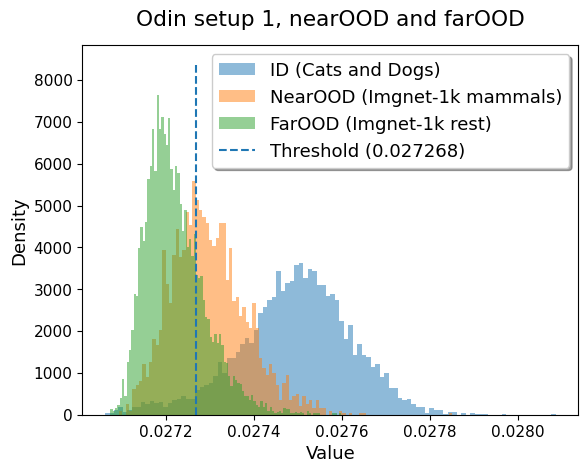

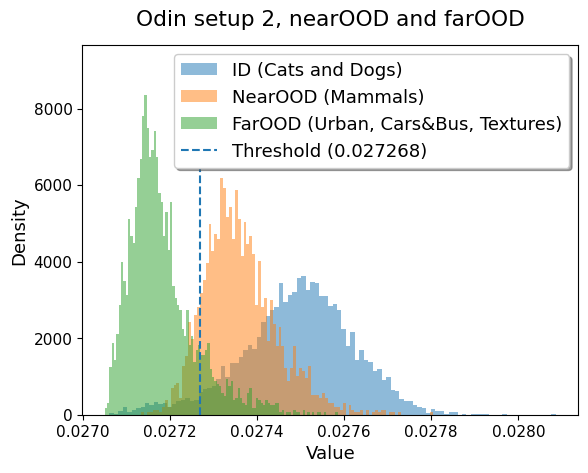

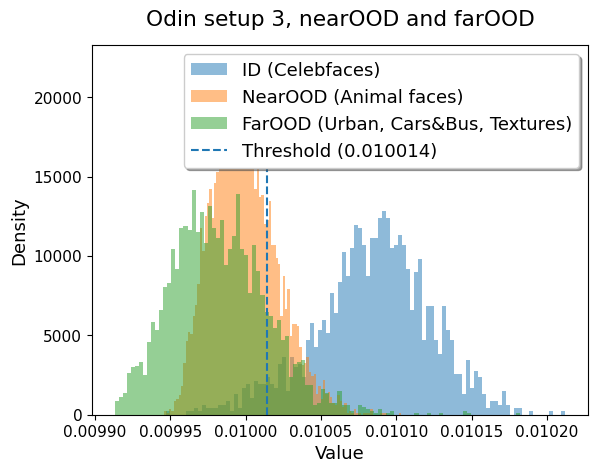

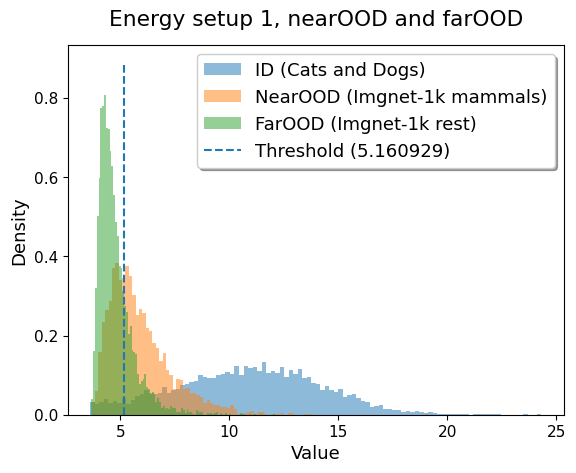

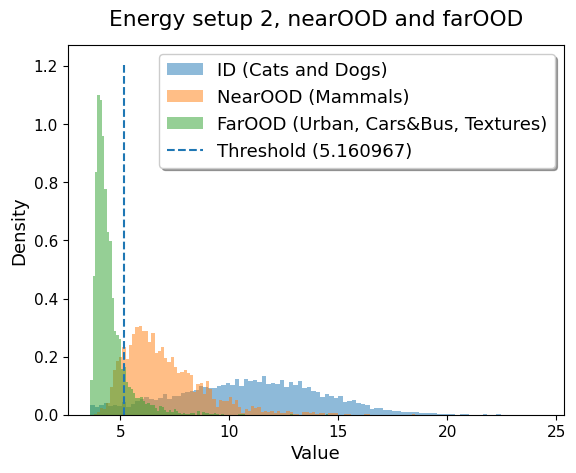

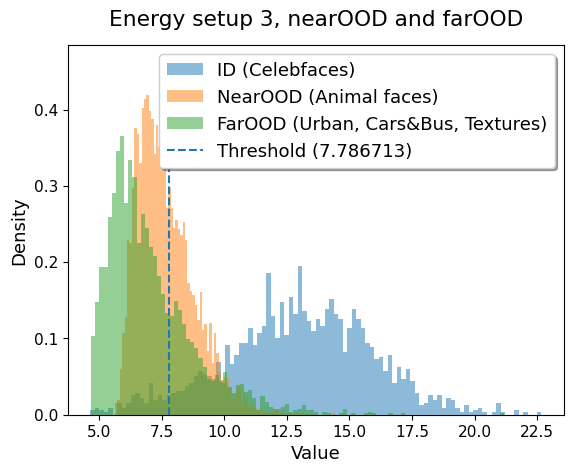

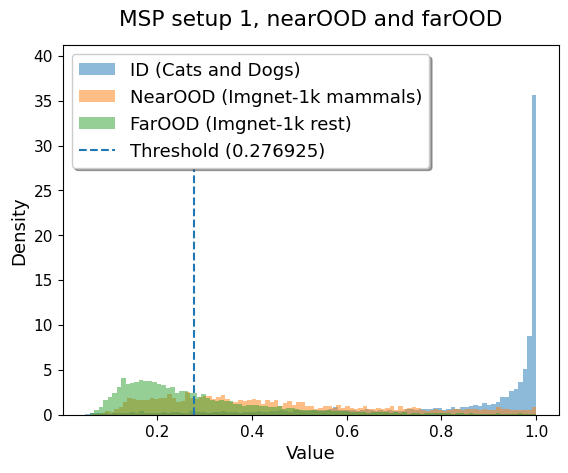

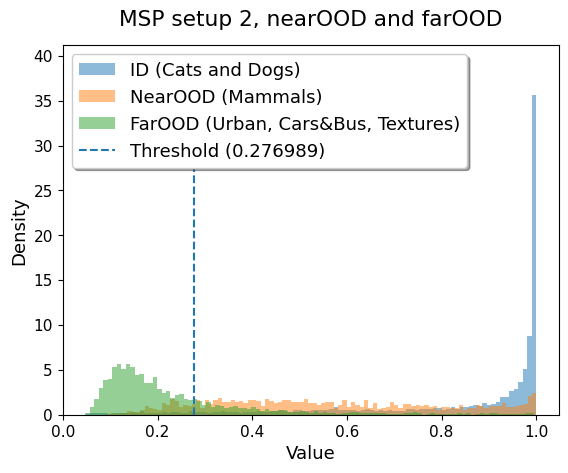

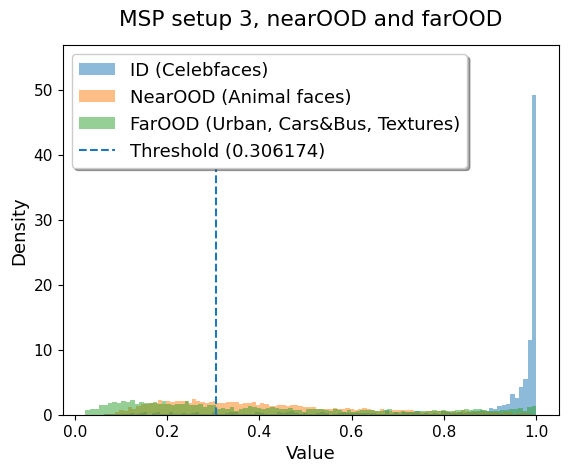

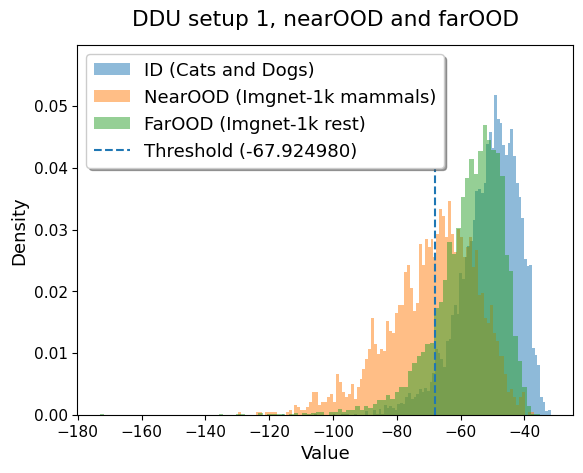

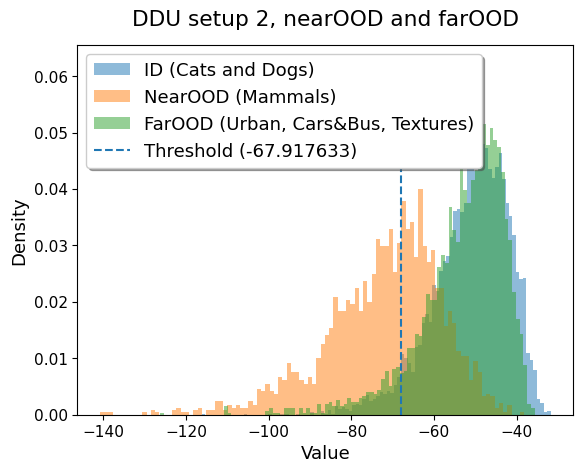

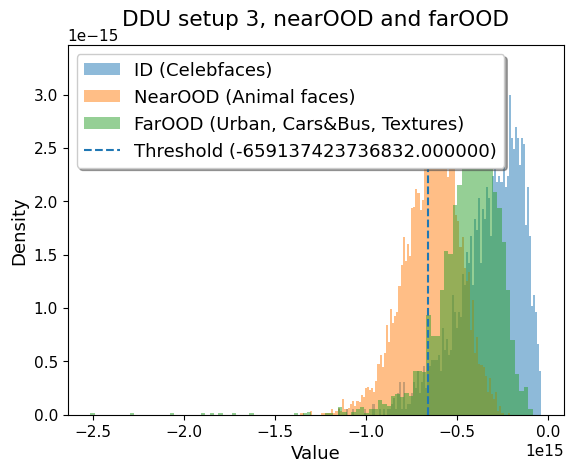

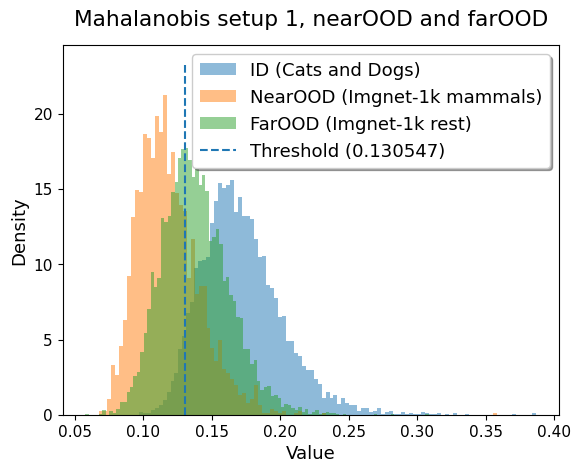

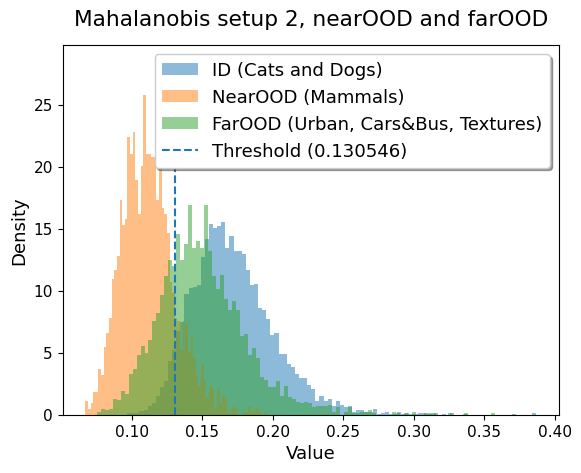

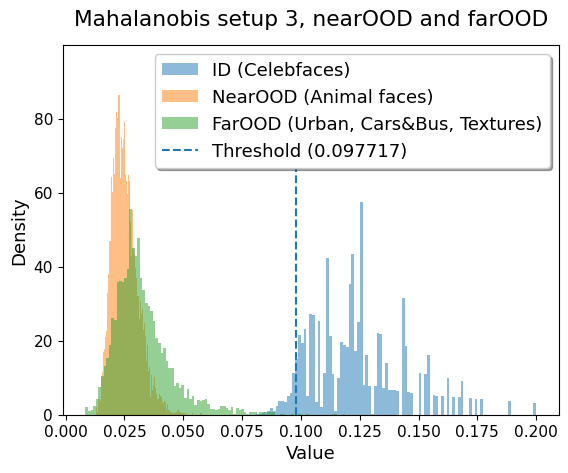

In [52]:
import matplotlib 

# Odin
visualizeThresholdOverlay(turmoil(odin_s12_in_examples), turmoil(s1_odin_near_out_examples), turmoil(s1_odin_far_out_examples), s1_odin_threshold, "Odin setup 1, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Imgnet-1k mammals)", "FarOOD (Imgnet-1k rest)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(odin_s12_in_examples), turmoil(s2_odin_near_out_examples), turmoil(s2_odin_far_out_examples), s2_odin_threshold, "Odin setup 2, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Mammals)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(odin_s3_in_examples), turmoil(s3_odin_near_out_examples), turmoil(s3_odin_far_out_examples), s3_odin_threshold, "Odin setup 3, nearOOD and farOOD", "ID (Celebfaces)", "NearOOD (Animal faces)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)

# Energy
visualizeThresholdOverlay(turmoil(energy_s12_in_examples), turmoil(s1_energy_near_out_examples), turmoil(s1_energy_far_out_examples), s1_energy_threshold, "Energy setup 1, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Imgnet-1k mammals)", "FarOOD (Imgnet-1k rest)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(energy_s12_in_examples), turmoil(s2_energy_near_out_examples), turmoil(s2_energy_far_out_examples), s2_energy_threshold, "Energy setup 2, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Mammals)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(energy_s3_in_examples), turmoil(s3_energy_near_out_examples), turmoil(s3_energy_far_out_examples), s3_energy_threshold, "Energy setup 3, nearOOD and farOOD", "ID (Celebfaces)", "NearOOD (Animal faces)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)

# MSP
visualizeThresholdOverlay(turmoil(msp_s12_in_examples), turmoil(s1_msp_near_out_examples), turmoil(s1_msp_far_out_examples), s1_msp_threshold, "MSP setup 1, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Imgnet-1k mammals)", "FarOOD (Imgnet-1k rest)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(msp_s12_in_examples), turmoil(s2_msp_near_out_examples), turmoil(s2_msp_far_out_examples), s2_msp_threshold, "MSP setup 2, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Mammals)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(msp_s3_in_examples), turmoil(s3_msp_near_out_examples), turmoil(s3_msp_far_out_examples), s3_msp_threshold, "MSP setup 3, nearOOD and farOOD", "ID (Celebfaces)", "NearOOD (Animal faces)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)

# DDU
visualizeThresholdOverlay(turmoil(s12_ddu_in_scores), turmoil(s1_ddu_near_out_examples), turmoil(s1_ddu_far_out_examples), s1_ddu_threshold, "DDU setup 1, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Imgnet-1k mammals)", "FarOOD (Imgnet-1k rest)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(s12_ddu_in_scores), turmoil(s2_ddu_near_out_examples), turmoil(s2_ddu_far_out_examples), s2_ddu_threshold, "DDU setup 2, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Mammals)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil(s3_ddu_in_scores), turmoil(s3_ddu_near_out_examples), turmoil(s3_ddu_far_out_examples), s3_ddu_threshold, "DDU setup 3, nearOOD and farOOD", "ID (Celebfaces)", "NearOOD (Animal faces)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)

# Mahalanobis
visualizeThresholdOverlay(turmoil_switch(s12_in_mahalanobis_distances), turmoil_switch(s1_maha_near_out_examples), turmoil_switch(s1_maha_far_out_examples), s1_maha_threshold, "Mahalanobis setup 1, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Imgnet-1k mammals)", "FarOOD (Imgnet-1k rest)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil_switch(s12_in_mahalanobis_distances), turmoil_switch(s2_maha_near_out_examples), turmoil_switch(s2_maha_far_out_examples), s2_maha_threshold, "Mahalanobis setup 2, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Mammals)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil_switch(s3_in_mahalanobis_distances), turmoil_switch(s3_maha_near_out_examples), turmoil_switch(s3_maha_far_out_examples), s3_maha_threshold, "Mahalanobis setup 3, nearOOD and farOOD", "ID (Celebfaces)", "NearOOD (Animal faces)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)



In [50]:
print("ODIN")
print(round(s1_odin_auroc, 4), round(s1_odin_aupr_in, 4), round(s1_odin_aupr_out, 4), round(s1_odin_fpr95, 4), round(s1_odin_threshold, 4))
print(round(s2_odin_auroc, 4), round(s2_odin_aupr_in, 4), round(s2_odin_aupr_out, 4), round(s2_odin_fpr95, 4), round(s2_odin_threshold, 4))
print(round(s3_odin_auroc, 4), round(s3_odin_aupr_in, 4), round(s3_odin_aupr_out, 4), round(s3_odin_fpr95, 4), round(s3_odin_threshold, 4))
print("")
print("Energy")
print(round(s1_energy_auroc, 4), round(s1_energy_aupr_in, 4), round(s1_energy_aupr_out, 4), round(s1_energy_fpr95, 4), round(s1_energy_threshold, 4))
print(round(s2_energy_auroc, 4), round(s2_energy_aupr_in, 4), round(s2_energy_aupr_out, 4), round(s2_energy_fpr95, 4), round(s2_energy_threshold, 4))
print(round(s3_energy_auroc, 4), round(s3_energy_aupr_in, 4), round(s3_energy_aupr_out, 4), round(s3_energy_fpr95, 4), round(s3_energy_threshold, 4))
print("")
print("MSP")
print(round(s1_msp_auroc, 4), round(s1_msp_aupr_in, 4), round(s1_msp_aupr_out, 4), round(s1_msp_fpr95, 4), round(s1_msp_threshold, 4))
print(round(s2_msp_auroc, 4), round(s2_msp_aupr_in, 4), round(s2_msp_aupr_out, 4), round(s2_msp_fpr95, 4), round(s2_msp_threshold, 4))
print(round(s3_msp_auroc, 4), round(s3_msp_aupr_in, 4), round(s3_msp_aupr_out, 4), round(s3_msp_fpr95, 4), round(s3_msp_threshold, 4))
print("")
print("DDU")
print(round(s1_ddu_auroc, 4), round(s1_ddu_aupr_in, 4), round(s1_ddu_aupr_out, 4), round(s1_ddu_fpr95, 4), round(s1_ddu_threshold, 4))
print(round(s2_ddu_auroc, 4), round(s2_ddu_aupr_in, 4), round(s2_ddu_aupr_out, 4), round(s2_ddu_fpr95, 4), round(s2_ddu_threshold, 4))
print(round(s3_ddu_auroc, 4), round(s3_ddu_aupr_in, 4), round(s3_ddu_aupr_out, 4), round(s3_ddu_fpr95, 4), round(s3_ddu_threshold, 4))
print("")
print("Mahalanobis")
print(round(s1_maha_auroc, 4), round(s1_maha_aupr_in, 4), round(s1_maha_aupr_out, 4), round(s1_maha_fpr95, 4), round(s1_maha_threshold, 4))
print(round(s2_maha_auroc, 4), round(s2_maha_aupr_in, 4), round(s2_maha_aupr_out, 4), round(s2_maha_fpr95, 4), round(s2_maha_threshold, 4))
print(round(s3_maha_auroc, 4), round(s3_maha_aupr_in, 4), round(s3_maha_aupr_out, 4), round(s3_maha_fpr95, 4), round(s3_maha_threshold, 4))


ODIN
0.9388 0.9379 0.9195 0.3308 0.0273
0.9026 0.9196 0.8675 0.4624 0.0273
0.966 0.9116 0.9902 0.2092 0.01

Energy
0.943 0.947 0.9174 0.3527 5.1609
0.9124 0.9327 0.8576 0.4551 5.161
0.946 0.8818 0.9792 0.3481 7.7867

MSP
0.9154 0.9151 0.8952 0.4939 0.2769
0.89 0.9154 0.8327 0.5235 0.277
0.9139 0.8261 0.9701 0.5923 0.3062

DDU
0.7354 0.695 0.7766 0.7629 -67.925
0.7073 0.7243 0.6977 0.706 -67.9176
0.8344 0.6229 0.9484 0.7005 -659137400000000.0

Mahalanobis
0.8539 0.8005 0.892 0.4918 0.1305
0.8207 0.7997 0.8316 0.4782 0.1305
0.9998 0.9997 0.9999 0.0006 0.0977


In [51]:
print("{:e}".format(-659137400000000.0))

-6.591374e+14


In [80]:
def chum(arr):
    return np.array([1/i for i in arr])

In [88]:
print("ODIN")
print(len(np.where(s1_odin_near_out_examples < s1_odin_threshold)[0]), len(np.where(s1_odin_far_out_examples < s1_odin_threshold)[0]))
print(len(np.where(s2_odin_near_out_examples < s2_odin_threshold)[0]), len(np.where(s2_odin_far_out_examples < s2_odin_threshold)[0]))
print(len(np.where(s3_odin_near_out_examples < s3_odin_threshold)[0]), len(np.where(s3_odin_far_out_examples < s3_odin_threshold)[0]))
print("")
print("Energy")
print(len(np.where(s1_energy_near_out_examples < s1_energy_threshold)[0]), len(np.where(s1_energy_far_out_examples < s1_energy_threshold)[0]))
print(len(np.where(s2_energy_near_out_examples < s2_energy_threshold)[0]), len(np.where(s2_energy_far_out_examples < s2_energy_threshold)[0]))
print(len(np.where(s3_energy_near_out_examples < s3_energy_threshold)[0]), len(np.where(s3_energy_far_out_examples < s3_energy_threshold)[0]))
print("")
print("MSP")
print(len(np.where(s1_msp_near_out_examples < s1_msp_threshold)[0]), len(np.where(s1_msp_far_out_examples < s1_msp_threshold)[0]))
print(len(np.where(s2_msp_near_out_examples < s2_msp_threshold)[0]), len(np.where(s2_msp_far_out_examples < s2_msp_threshold)[0]))
print(len(np.where(s3_msp_near_out_examples < s3_msp_threshold)[0]), len(np.where(s3_msp_far_out_examples < s3_msp_threshold)[0]))
print("")
print("DDU")
print(len(np.where(s1_ddu_near_out_examples < s1_ddu_threshold)[0]), len(np.where(s1_ddu_far_out_examples < s1_ddu_threshold)[0]))
print(len(np.where(s2_ddu_near_out_examples < s2_ddu_threshold)[0]), len(np.where(s2_ddu_far_out_examples < s2_ddu_threshold)[0]))
print(len(np.where(s3_ddu_near_out_examples < s3_ddu_threshold)[0]), len(np.where(s3_ddu_far_out_examples < s3_ddu_threshold)[0]))
print("")
print("Mahalanobis")
print(len(np.where(chum(s1_maha_near_out_examples) < s1_maha_threshold)[0]), len(np.where(chum(s1_maha_far_out_examples) < s1_maha_threshold)[0]))
print(len(np.where(chum(s2_maha_near_out_examples) < s2_maha_threshold)[0]), len(np.where(chum(s2_maha_far_out_examples) < s2_maha_threshold)[0]))
print(len(np.where(chum(s3_maha_near_out_examples) < s3_maha_threshold)[0]), len(np.where(chum(s3_maha_far_out_examples) < s3_maha_threshold)[0]))


ODIN
1041 4748
256 2613
3983 2529

Energy
934 4665
284 2624
3177 2191

MSP
762 3616
301 2242
1957 1400

DDU
1229 822
1317 252
2217 249

Mahalanobis
1954 2442
1990 795
5238 2992


In [89]:
print("ODIN")
print(round(len(np.where(s1_odin_near_out_examples < s1_odin_threshold)[0])/len(s1_odin_near_out_examples)*100, 4), round(len(np.where(s1_odin_far_out_examples < s1_odin_threshold)[0])/len(s1_odin_far_out_examples)*100, 4))
print(round(len(np.where(s2_odin_near_out_examples < s2_odin_threshold)[0])/len(s2_odin_near_out_examples)*100, 4), round(len(np.where(s2_odin_far_out_examples < s2_odin_threshold)[0])/len(s2_odin_far_out_examples)*100, 4))
print(round(len(np.where(s3_odin_near_out_examples < s3_odin_threshold)[0])/len(s3_odin_near_out_examples)*100, 4), round(len(np.where(s3_odin_far_out_examples < s3_odin_threshold)[0])/len(s3_odin_far_out_examples)*100, 4))
print("")
print("Energy")
print(round(len(np.where(s1_energy_near_out_examples < s1_energy_threshold)[0])/len(s1_energy_near_out_examples)*100, 4), round(len(np.where(s1_energy_far_out_examples < s1_energy_threshold)[0])/len(s1_energy_far_out_examples)*100, 4))
print(round(len(np.where(s2_energy_near_out_examples < s2_energy_threshold)[0])/len(s2_energy_near_out_examples)*100, 4), round(len(np.where(s2_energy_far_out_examples < s2_energy_threshold)[0])/len(s2_energy_far_out_examples)*100, 4))
print(round(len(np.where(s3_energy_near_out_examples < s3_energy_threshold)[0])/len(s3_energy_near_out_examples)*100, 4), round(len(np.where(s3_energy_far_out_examples < s3_energy_threshold)[0])/len(s3_energy_far_out_examples)*100, 4))
print("")
print("MSP")
print(round(len(np.where(s1_msp_near_out_examples < s1_msp_threshold)[0])/len(s1_msp_near_out_examples)*100, 4), round(len(np.where(s1_msp_far_out_examples < s1_msp_threshold)[0])/len(s1_msp_far_out_examples)*100, 4))
print(round(len(np.where(s2_msp_near_out_examples < s2_msp_threshold)[0])/len(s2_msp_near_out_examples)*100, 4), round(len(np.where(s2_msp_far_out_examples < s2_msp_threshold)[0])/len(s2_msp_far_out_examples)*100, 4))
print(round(len(np.where(s3_msp_near_out_examples < s3_msp_threshold)[0])/len(s3_msp_near_out_examples)*100, 4), round(len(np.where(s3_msp_far_out_examples < s3_msp_threshold)[0])/len(s3_msp_far_out_examples)*100, 4))
print("")
print("DDU")
print(round(len(np.where(s1_ddu_near_out_examples < s1_ddu_threshold)[0])/len(s1_ddu_near_out_examples)*100, 4), round(len(np.where(s1_ddu_far_out_examples < s1_ddu_threshold)[0])/len(s1_ddu_far_out_examples)*100, 4))
print(round(len(np.where(s2_ddu_near_out_examples < s2_ddu_threshold)[0])/len(s2_ddu_near_out_examples)*100, 4), round(len(np.where(s2_ddu_far_out_examples < s2_ddu_threshold)[0])/len(s2_ddu_far_out_examples)*100, 4))
print(round(len(np.where(s3_ddu_near_out_examples < s3_ddu_threshold)[0])/len(s3_ddu_near_out_examples)*100, 4), round(len(np.where(s3_ddu_far_out_examples < s3_ddu_threshold)[0])/len(s3_ddu_far_out_examples)*100, 4))
print("")
print("Mahalanobis")
print(round(len(np.where(chum(s1_maha_near_out_examples) < s1_maha_threshold)[0])/len(s1_maha_near_out_examples)*100, 4), round(len(np.where(chum(s1_maha_far_out_examples) < s1_maha_threshold)[0])/len(s1_maha_far_out_examples)*100, 4))
print(round(len(np.where(chum(s2_maha_near_out_examples) < s2_maha_threshold)[0])/len(s2_maha_near_out_examples)*100, 4), round(len(np.where(chum(s2_maha_far_out_examples) < s2_maha_threshold)[0])/len(s2_maha_far_out_examples)*100, 4))
print(round(len(np.where(chum(s3_maha_near_out_examples) < s3_maha_threshold)[0])/len(s3_maha_near_out_examples)*100, 4), round(len(np.where(chum(s3_maha_far_out_examples) < s3_maha_threshold)[0])/len(s3_maha_far_out_examples)*100, 4))

ODIN
39.7328 78.7396
10.9402 87.1872
76.0405 84.3844

Energy
35.6489 77.3632
12.1368 87.5542
60.6529 73.1064

MSP
29.084 59.9668
12.8632 74.8081
37.3616 46.7134

DDU
46.9084 13.6318
56.2821 8.4084
42.3253 8.3083

Mahalanobis
74.5802 40.4975
85.0427 26.5265
100.0 99.8332


In [86]:
print(len(s1_odin_near_out_examples), len(s1_odin_far_out_examples))
print(len(s2_odin_near_out_examples), len(s2_odin_far_out_examples))
print(len(s3_odin_near_out_examples), len(s3_odin_far_out_examples))

2620 6030
2340 2997
5238 2997


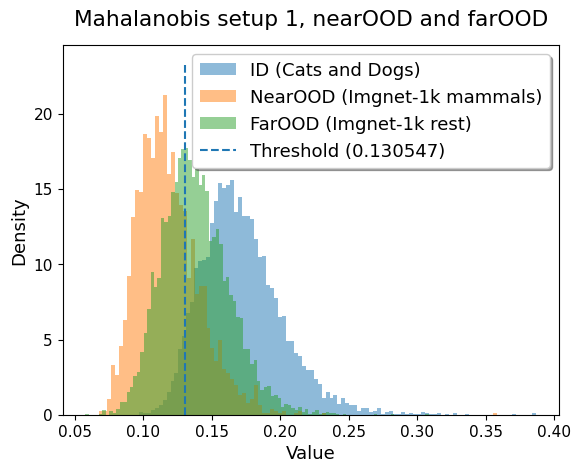

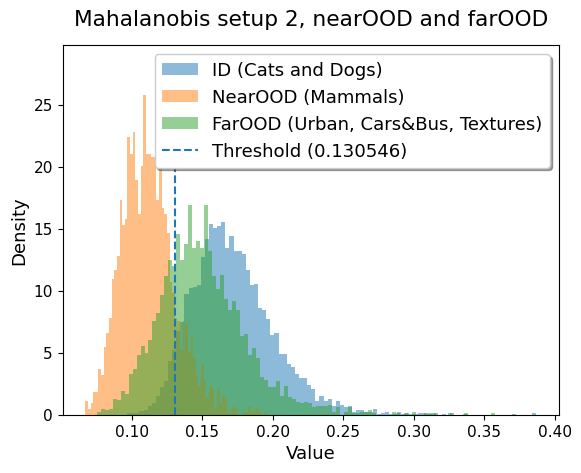

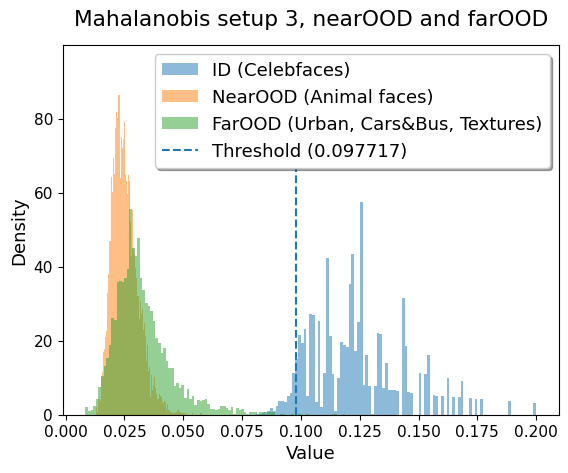

In [87]:
visualizeThresholdOverlay(turmoil_switch(s12_in_mahalanobis_distances), turmoil_switch(s1_maha_near_out_examples), turmoil_switch(s1_maha_far_out_examples), s1_maha_threshold, "Mahalanobis setup 1, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Imgnet-1k mammals)", "FarOOD (Imgnet-1k rest)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil_switch(s12_in_mahalanobis_distances), turmoil_switch(s2_maha_near_out_examples), turmoil_switch(s2_maha_far_out_examples), s2_maha_threshold, "Mahalanobis setup 2, nearOOD and farOOD", "ID (Cats and Dogs)", "NearOOD (Mammals)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
visualizeThresholdOverlay(turmoil_switch(s3_in_mahalanobis_distances), turmoil_switch(s3_maha_near_out_examples), turmoil_switch(s3_maha_far_out_examples), s3_maha_threshold, "Mahalanobis setup 3, nearOOD and farOOD", "ID (Celebfaces)", "NearOOD (Animal faces)", "FarOOD (Urban, Cars&Bus, Textures)", cov=False, alpha=0.5, plot = True, extra_plot=False)
